In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

import skimage.io as io
from skimage import util

from glob import glob
import trackpy

import ast
from ipywidgets import widgets


from ipywidgets.embed import embed_minimal_html

## Read data

In [2]:
file_list=glob("../data/*_Dark_prepared.tif")
images_dict={}
for file_name in file_list:
    images_prepared=io.imread(file_name)
    file_prefix=os.path.split(file_name)[1].split('.')[0].split("_prepared")[0]
    
    binary_file=file_name.split(".tif")[0]+'_segmented'+'.tif'
    images_binary=io.imread(binary_file)
    tracks=pd.read_csv("../data/tracks_overlay_id_"+file_prefix+'.csv')
    tracks_big=pd.read_csv("../data/tracks_overlay_id_"+file_prefix+'_big.csv')
    img_dict={"img":images_prepared,"binary":images_binary,"tracks":tracks,"tracks_big":tracks_big}
    
    images_dict[file_prefix]=img_dict

## Object widjets

In [82]:
file_prefix="43125_Dark"
particle=18


# 'major_axis_length','minor_axis_length', 'orientation', 'area', 'perimeter', 'eccentricity',
#'max_intensity','mean_intensity', 'min_intensity', 'compactness', 'circularity','contrast',  'file_name', 'particle'
column_name='area'

###========================================####
tracks=images_dict[file_prefix]["tracks_big"]
images=images_dict[file_prefix]["img"]
binary=images_dict[file_prefix]["binary"]


traj=tracks[tracks["particle"]==particle]

delta=10
min_row,min_col=np.min(traj.loc[:,'bbox-0':'bbox-1'])
max_row,max_col=np.max(traj.loc[:,'bbox-2':'bbox-3'])

start_frame=np.min(traj.loc[:,'frame'])
end_frame=np.max(traj.loc[:,'frame'])

min_row=np.max([min_row-delta,0])
min_col=np.max([min_col-delta,0])
max_row=np.min([max_row+delta,images[0].shape[0]])
max_col=np.min([max_col+delta,images[0].shape[1]])
               
traj_img=images[:,min_row:max_row,min_col:max_col]
traj_seg=binary[:,min_row:max_row,min_col:max_col]


###========================================####
def plot_plane(frame):
    fig,ax=plt.subplots(nrows=1,ncols=3,figsize=(20,5))
    # particle image
    ax[0].imshow(traj_img[frame],cmap='gray')
    ax[0].axis("off")
    
    # particle image
    ax[1].imshow(traj_seg[frame],cmap='gray')
    ax[1].axis("off")
        
    # area vs frame plot
    
    ax[2].plot(traj.frame,traj[column_name],'-o')
    ax[2].axvline(x=frame,color='red')
    ax[2].set_title(column_name)
    ax[2].set_xlabel("frame")
    ax[2].set_ylabel(column_name)
    plt.show()

intSlider=widgets.IntSlider(min=start_frame,max=end_frame,step=1,value=0)    
play_w=widgets.Play(value=0,min=start_frame,max=end_frame,interval=200,description="Press play",disabled=False)
widgets.jslink((play_w, 'value'), (intSlider, 'value'))


int_w=widgets.interactive(plot_plane,frame = intSlider)
container=widgets.VBox([play_w,int_w])

display(container)

#from ipywidgets.embed import embed_minimal_html
embed_minimal_html('../results/export.html', views=container, title='Widgets export')

IndexError: single positional indexer is out-of-bounds

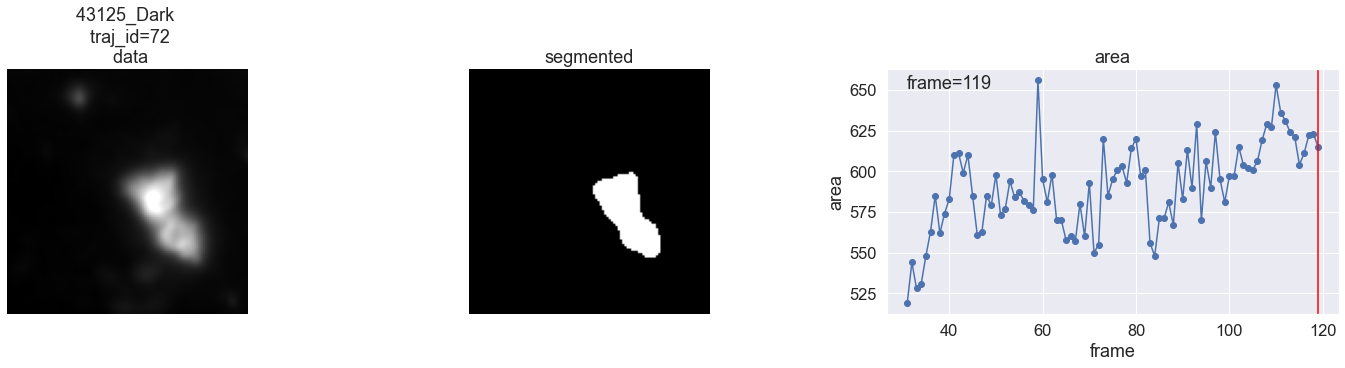

In [6]:
import matplotlib.animation as animation
sns.set(font_scale=1.5)
fps = 2
nFrames=traj_img.shape[0]

###===== init plot ==============================#
# First set up the figure, the axis, and the plot element we want to animate

fig,ax=plt.subplots(nrows=1,ncols=3,figsize=(20,5),constrained_layout=True)
# particle image
im1=ax[0].imshow(traj_img[0],cmap='gray')
ax[0].set_title("{} \n traj_id={}\n data".format(file_prefix, particle))
ax[0].axis("off")
    
# particle image
im2=ax[1].imshow(traj_seg[0],cmap='gray')
ax[1].axis("off")
ax[1].set_title("segmented")
        
# area vs frame plot
ax[2].plot(traj.frame,traj["area"],'-o')
axvline=ax[2].axvline(x=traj.frame.iloc[0],color='red')
annotation_axvline = ax[2].annotate('frame={}'.format(traj.frame.iloc[0]), 
                                    xy=(traj.frame.iloc[0], traj["area"].iloc[0]),
                                    xytext=(traj.frame.iloc[0],np.max(traj["area"])-5))
ax[2].set_title('area')
ax[2].set_xlabel("frame")
ax[2].set_ylabel('area');


###======================================#


def animate_func(i):
    im1.set_data(traj_img[i])
    im2.set_data(traj_seg[i])
    
    frame=traj.frame.iloc[i]
    axvline.set_data([frame,frame],[0,1])
    annotation_axvline.set_text('frame={}'.format(traj.frame.iloc[i]))
    return [im1,im2]

anim = animation.FuncAnimation(
                               fig, 
                               animate_func, 
                               frames = nFrames-1,
                               interval = 1000 / fps, # in ms
                               )

anim.save('../results/Experiment_{}_Id{}.mp4'.format(file_prefix,particle), fps=fps, extra_args=['-vcodec', 'libx264'])

print('Done!')

## Anchor points Viz

In [61]:
def select_from_dict(images_dict,file_prefix,particle):
    ###========================================####
    tracks=images_dict[file_prefix]["tracks_big"]
    images=images_dict[file_prefix]["img"]
    binary=images_dict[file_prefix]["binary"]
    traj=tracks[tracks["particle"]==particle]

    delta=10
    min_row,min_col=np.min(traj.loc[:,'bbox-0':'bbox-1'])
    max_row,max_col=np.max(traj.loc[:,'bbox-2':'bbox-3'])

    start_frame=np.min(traj.loc[:,'frame'])
    end_frame=np.max(traj.loc[:,'frame'])

    min_row=np.max([min_row-delta,0])
    min_col=np.max([min_col-delta,0])
    max_row=np.min([max_row+delta,images[0].shape[0]])
    max_col=np.min([max_col+delta,images[0].shape[1]])
               
    traj_img=images[start_frame:end_frame+1,min_row:max_row,min_col:max_col]
    traj_seg=binary[start_frame:end_frame+1,min_row:max_row,min_col:max_col]
    
    return traj_img,traj_seg,traj,start_frame,end_frame
    

In [62]:
file_prefix="43123_Dark"
particle=36

traj_img,traj_seg,traj,start_frame,end_frame=select_from_dict(images_dict,file_prefix,particle)

###========================================####
def plot_plane(frame):
    fig,ax=plt.subplots(nrows=1,ncols=3,figsize=(20,5))
    # particle image
    ax[0].imshow(traj_img[frame],cmap='gray')
    ax[0].axis("off")
    
    # particle image
    anchor_map=np.sum(traj_seg,axis=0)
    rgb_map=np.zeros((traj_seg[frame].shape[0],traj_seg[frame].shape[1],3))
    anchor=anchor_map>=(255*(traj_seg.shape[0]-1))
    rgb_map[anchor]=(1,0,0)
    rgb_map[(traj_seg[frame]>0)&(anchor==False)]=(0,1,0)

    ax[1].imshow(rgb_map,cmap='gray')
    ax[1].axis("off")
    
    # particle image
    values=np.mean(traj.area)*255*0.13
    ax[2].imshow(np.sum(traj_seg,axis=0),vmin=255,vmax=(255*(traj_seg.shape[0]-5)),cmap='plasma')
    ax[2].axis("off")
        

intSlider=widgets.IntSlider(min=start_frame,max=end_frame,step=1,value=0)    
play_w=widgets.Play(value=0,min=start_frame,max=end_frame,interval=200,description="Press play",disabled=False)
widgets.jslink((play_w, 'value'), (intSlider, 'value'))


int_w=widgets.interactive(plot_plane,frame = intSlider)
container=widgets.VBox([play_w,int_w])

display(container)

#from ipywidgets.embed import embed_minimal_html
#embed_minimal_html('../results/export.html', views=container, title='Widgets export')

## Animation 

In [30]:
def plot_scale_bar(ax,px_micron=1.42,size=10):
    n_pixels=size/px_micron
    rows,cols=traj_seg.shape[1],traj_seg.shape[2]
    col_start=(cols-n_pixels)-100
    row_start=(rows-5)
    ax.plot([col_start,col_start+n_pixels],[row_start,row_start],color='cyan')
    ax.text(col_start+1,row_start-2,s="{} microns".format(size),color="cyan")
    print(n_pixels)


In [31]:
def select_region_particle(file_prefix,particle):
    ###========================================####
    tracks=images_dict[file_prefix]["tracks"]
    images=images_dict[file_prefix]["img"]
    binary=images_dict[file_prefix]["binary"]


    traj=tracks[tracks["particle"]==particle]

    delta=15
    min_row,min_col=np.min(traj.loc[:,'bbox-0':'bbox-1'])
    max_row,max_col=np.max(traj.loc[:,'bbox-2':'bbox-3'])

    start_frame=np.min(traj.loc[:,'frame'])
    end_frame=np.max(traj.loc[:,'frame'])

    min_row=np.max([min_row-delta,0])
    min_col=np.max([min_col-delta,0])
    max_row=np.min([max_row+delta,images[0].shape[0]])
    max_col=np.min([max_col+delta,images[0].shape[1]])
               
    traj_img=images[:,min_row:max_row,min_col:max_col]
    traj_seg=binary[:,min_row:max_row,min_col:max_col]
    return traj_seg


def plot_density_plot(traj_seg,ax):
    
    anchor_map=np.sum(traj_seg,axis=0)
    ax.imshow(anchor_map,vmin=255,vmax=np.max(anchor_map),cmap='plasma')
    
  
    


###  one object

7.042253521126761


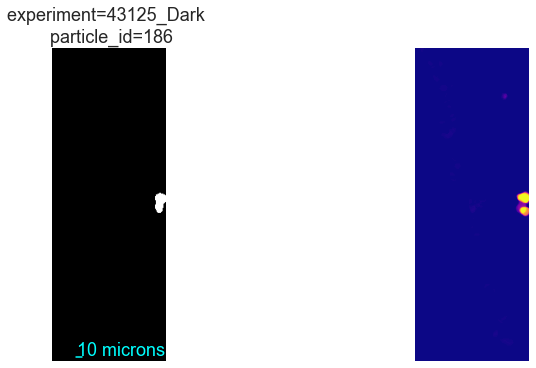

In [32]:
file_prefix="43125_Dark"
particle=186
traj_seg=select_region_particle(file_prefix,particle)


import matplotlib.animation as animation
sns.set(font_scale=1.5)
fps = 10
nFrames=traj_seg.shape[0]




###===== init plot ==============================#
# First set up the figure, the axis, and the plot element we want to animate

fig,ax=plt.subplots(nrows=1,ncols=2,figsize=(10,5),constrained_layout=True)
# particle image
im=ax[0].imshow(traj_seg[0],cmap='gray')
plot_density_plot(traj_seg,ax[1])

ax[0].axis("off")
ax[1].axis("off")
ax[0].set_title("experiment={} \n particle_id={}".format(file_prefix,particle))
plot_scale_bar(ax[0],px_micron=1.42,size=10)
        



# ###======================================#


def animate_func(i):
    im.set_data(traj_seg[i])
    return [im]

anim = animation.FuncAnimation(
                               fig, 
                               animate_func, 
                               frames = nFrames-1,
                               interval = 1000 / fps/100, # in ms
                               )

anim.save('../results/One_object_{}_Id{}.mp4'.format(file_prefix,particle), fps=fps, extra_args=['-vcodec', 'libx264'])

# print('Done!')

### something different

CalledProcessError: Command '['ffmpeg', '-f', 'rawvideo', '-vcodec', 'rawvideo', '-s', '1440x360', '-pix_fmt', 'rgba', '-r', '2', '-loglevel', 'error', '-i', 'pipe:', '-vcodec', 'h264', '-pix_fmt', 'yuv420p', '-vcodec', 'libx264', '-y', '../results/Experiment_43125_Dark_Id72.mp4']' returned non-zero exit status 255.

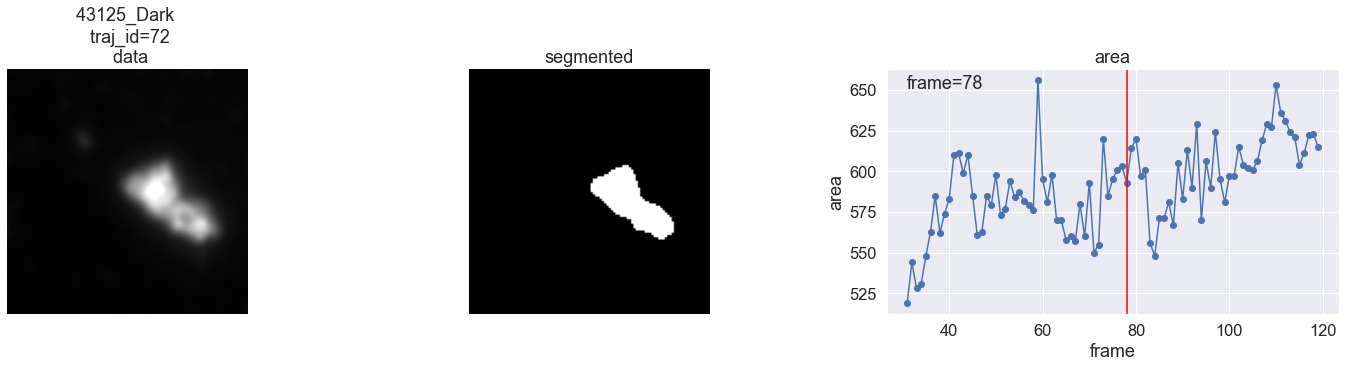

In [35]:
import matplotlib.animation as animation
sns.set(font_scale=1.5)
fps = 2
nFrames=traj_img.shape[0]

###===== init plot ==============================#
# First set up the figure, the axis, and the plot element we want to animate

fig,ax=plt.subplots(nrows=1,ncols=3,figsize=(20,5),constrained_layout=True)
# particle image
im1=ax[0].imshow(traj_img[0],cmap='gray')
ax[0].set_title("{} \n traj_id={}\n data".format(file_prefix, particle))
ax[0].axis("off")
    
# particle image
im2=ax[1].imshow(traj_seg[0],cmap='gray')
ax[1].axis("off")
ax[1].set_title("segmented")
        
# area vs frame plot
ax[2].plot(traj.frame,traj["area"],'-o')
axvline=ax[2].axvline(x=traj.frame.iloc[0],color='red')
annotation_axvline = ax[2].annotate('frame={}'.format(traj.frame.iloc[0]), 
                                    xy=(traj.frame.iloc[0], traj["area"].iloc[0]),
                                    xytext=(traj.frame.iloc[0],np.max(traj["area"])-5))
ax[2].set_title('area')
ax[2].set_xlabel("frame")
ax[2].set_ylabel('area');


###======================================#


def animate_func(i):
    im1.set_data(traj_img[i])
    im2.set_data(traj_seg[i])
    
    frame=traj.frame.iloc[i]
    axvline.set_data([frame,frame],[0,1])
    annotation_axvline.set_text('frame={}'.format(traj.frame.iloc[i]))
    return [im1,im2]

anim = animation.FuncAnimation(
                               fig, 
                               animate_func, 
                               frames = nFrames-1,
                               interval = 1000 / fps, # in ms
                               )

anim.save('../results/Experiment_{}_Id{}.mp4'.format(file_prefix,particle), fps=fps, extra_args=['-vcodec', 'libx264'])

print('Done!')

## Trajectories viz

In [21]:
file_prefix="43125_Dark"
particle=72

# 'major_axis_length','minor_axis_length', 'orientation', 'area', 'perimeter', 'eccentricity',
#'max_intensity','mean_intensity', 'min_intensity', 'compactness', 'circularity','contrast',  'file_name', 'particle'
column_name='area'

###========================================####
tracks=images_dict[file_prefix]["tracks_big"]
images=images_dict[file_prefix]["img"]
binary=images_dict[file_prefix]["binary"]


traj=tracks[tracks["particle"]==particle]

delta=10
min_row,min_col=np.min(traj.loc[:,'bbox-0':'bbox-1'])
max_row,max_col=np.max(traj.loc[:,'bbox-2':'bbox-3'])

start_frame=np.min(traj.loc[:,'frame'])
end_frame=np.max(traj.loc[:,'frame'])

min_row=np.max([min_row-delta,0])
min_col=np.max([min_col-delta,0])
max_row=np.min([max_row+delta,images[0].shape[0]])
max_col=np.min([max_col+delta,images[0].shape[1]])
               
traj_img=images[:,min_row:max_row,min_col:max_col]
traj_seg=binary[:,min_row:max_row,min_col:max_col]


###========================================####
def plot_plane(frame):
    fig,ax=plt.subplots(nrows=1,ncols=3,figsize=(20,5))
    # particle image
    ax[0].imshow(traj_img[frame],cmap='gray')
    ax[0].axis("off")
    
    # particle image
    ax[1].imshow(traj_seg[frame],cmap='gray')
    ax[1].axis("off")
        
    # area vs frame plot
    
    ax[2].plot(traj.frame,traj['area'],'-o')
    ax[2].axvline(x=frame,color='red')
    ax[2].set_title(column_name)
    ax[2].set_xlabel("frame")
    ax[2].set_ylabel(column_name)
    plt.show()

intSlider=widgets.IntSlider(min=start_frame,max=end_frame,step=1,value=0)    
play_w=widgets.Play(value=0,min=start_frame,max=end_frame,interval=200,description="Press play",disabled=False)
widgets.jslink((play_w, 'value'), (intSlider, 'value'))


int_w=widgets.interactive(plot_plane,frame = intSlider)
container=widgets.VBox([widgets.HBox([play_w]),int_w])

display(container)


Text(0.5, 1.0, 'R view')

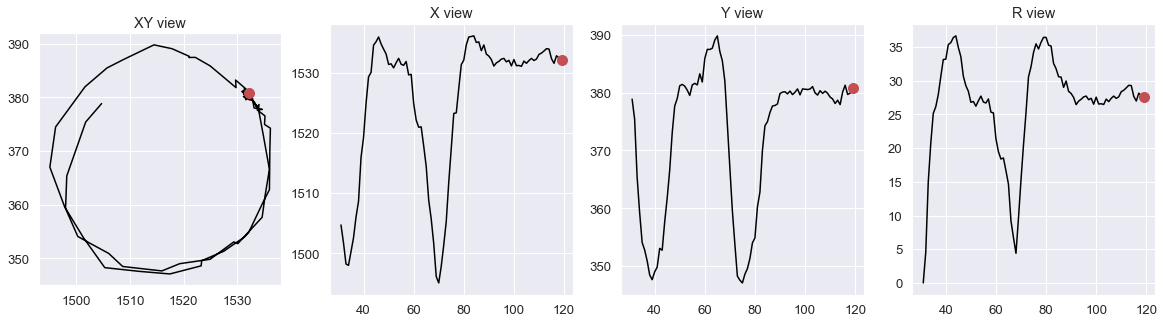

In [38]:
frame=119
traj_part=traj[traj['frame']<=frame]

sns.set(font_scale=1.2)
fig,ax=plt.subplots(nrows=1,ncols=4,figsize=(20,5))
ax[0].plot(traj_part['x'],traj_part['y'],color='black')
ax[0].plot(traj_part['x'].values[-1],traj_part['y'].values[-1],"ro", markersize=10)
ax[0].set_aspect('equal', 'box')
ax[0].set_title("XY view")

ax[1].plot(traj_part['frame'],traj_part['x'],color='black')
ax[1].plot(traj_part['frame'].values[-1],traj_part['x'].values[-1],"ro", markersize=10)
ax[1].set_title("X view")
ax[2].plot(traj_part['frame'],traj_part['y'],color='black')
ax[2].plot(traj_part['frame'].values[-1],traj_part['y'].values[-1],"ro", markersize=10)
ax[2].set_title("Y view")

# radius vector
start_x=traj['x'].values[0]
start_y=traj['y'].values[0]
r=np.sqrt((traj_part['x'].values-start_x)**2+(traj_part['y'].values-start_y)**2)
ax[3].plot(traj_part['frame'],r,color='black')
ax[3].plot(traj_part['frame'].values[-1],r[-1],"ro", markersize=10)
ax[3].set_title("R view")
    